<img src="https://raw.githubusercontent.com/Sengsathit/OCR_data_scientist_assets/main/header_place_de_marche.png" alt="Alternative text" />

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Initialisation](#toc2_)    
  - [Importation et configurations](#toc2_1_)    
  - [Chargement des données](#toc2_2_)    
  - [Hyper-paramètres pour la classification](#toc2_3_)    
- [Fonctions ré-utilisables](#toc3_)    
- [Classification avec Data Augmentation](#toc4_)    
  - [Flux de données (Train, Validation, Test)](#toc4_1_)    
  - [Entraînement du modèle](#toc4_2_)    
  - [Évaluation du modèle](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)

L'objectif de ce notebook est de démontrer le processus complet d'un classification supervisée d'images en utilisant un réseau de neurones et des techniques d'augmentation des données.\
Le travail consiste à préparer les données, d'entraînement, d'évaluation et de test puis d'entraîner et d'évaluer le modèle de réseau de neurones pour affiner et améliorer le modèle pour une meilleure généralisation.

# <a id='toc2_'></a>[Initialisation](#toc0_)

## <a id='toc2_1_'></a>[Importation et configurations](#toc0_)

In [1]:
# Bibliothèque standard
import random

# Manipulation des données
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# CNN
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Visualisation
import matplotlib.pyplot as plt
from plot_keras_history import show_history, plot_history

random.seed(42)
np.random.seed(42)

# Configurer Pandas pour un affichage complet du contenu des colonnes
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = '#FFFCF7'    # Définir la couleur de fond de la figure
plt.rcParams['axes.facecolor'] = '#FFFCF7'      # Définir la couleur de fond des axes

/var/folders/59/q0j81gmx5h7gvpg38k8hknzw0000gn/T/ipykernel_37960/2051040955.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## <a id='toc2_2_'></a>[Chargement des données](#toc0_)

Préparation d'un DataFrame en extrayant les données nécessaires à l'entraînement du modèle.

Les images, initialement de tailles variées, ont été éditées pour adopter un format carré de 800x800, tout en respectant leurs proportions d'origine.

In [2]:
df = pd.read_csv('../datasets/flipkart_cleaned.csv')
images_path = '../datasets/flipkart/images_800_800/'

data = pd.DataFrame()
data['image_path'] = images_path + df['image']
data['category'] = df['_category']
        
data.head()

,image_path,category
0,../datasets/flipkart/images_800_800/55b85ea15a...,home furnishing
1,../datasets/flipkart/images_800_800/7b72c92c2f...,baby care
2,../datasets/flipkart/images_800_800/64d5d4a258...,baby care
3,../datasets/flipkart/images_800_800/d4684dcdc7...,home furnishing
4,../datasets/flipkart/images_800_800/6325b6870c...,home furnishing


Séparation du dataset original en DataFrame d'entraînement et de test.

In [3]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['category'])

## <a id='toc2_3_'></a>[Hyper-paramètres pour la classification](#toc0_)

In [4]:
# Largeur et hauteur des images à utiliser comme entrée pour le réseau de neurones
image_width = 224
image_height = 224

# Taille du lot : le nombre d'images à traiter en même temps par le réseau de neurones lors de l'entraînement
batch_size = 32

# <a id='toc3_'></a>[Fonctions ré-utilisables](#toc0_)

In [5]:
def get_vgg16_model():
    """
    Crée un modèle basé sur VGG16 pré-entraîné avec des couches supplémentaires pour la classification.

    Le modèle VGG16 est utilisé comme base, avec ses couches rendues non-entraînables.
    Des couches de pooling, dense et de dropout sont ajoutées pour la classification en 7 catégories.
    Le modèle est compilé avec un loss de type "categorical_crossentropy" et un optimiseur "rmsprop".

    Returns:
        model (Model): Le modèle de classification compilé.
    """
    # Charger le modèle VGG16 pré-entraîné sans la couche de sortie finale
    vgg16_model = VGG16(
        include_top=False,                          # Exclusion des couches fully connected              
        weights="imagenet",                         # Sélection du modèle pré-entraîné sur ImageNet
        input_shape=(image_width, image_height, 3)  # Définition de la forme d'entrée (largeur, hauteur, canaux)  
    )

    # Rendre les couches du modèle VGG16 non-entraînables pour conserver les caractéristiques extraites par le modèle pré-entraîné sur ImageNet
    for layer in vgg16_model.layers:
        layer.trainable = False

    # Ajouter des couches supplémentaires au modèle
    x = vgg16_model.output
    x = Flatten()(x)                                # Transformation des cartes de caractéristiques en un vecteur 1D
    x = Dense(256, activation='relu')(x)            # Couche entièrement connectée pour apprendre des caractéristiques extraites par les couches précédentes
    x = Dense(128, activation='relu')(x)            # Couche entièrement connectée pour apprendre des caractéristiques extraites par les couches précédentes
    x = Dropout(0.5)(x)                             # Technique pour réduire le surapprentissage en désactivant de manière aléatoire une fraction des unités (neurones) pendant l'entraînement
    predictions = Dense(7, activation='softmax')(x) # Couche de sortie du modèle de classification muliclasses, transforme les caractéristiques extraites en un ensemble de probabilités

    # Créer le nouveau modèle
    model = Model(inputs=vgg16_model.input, outputs=predictions, name='custom_vgg16_model')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Afficher un résumé du modèle
    print(model.summary())

    return model

In [6]:

def data_flow(data, datagen, data_type=None):
    """
    Génère un flux de données pour l'entraînement, la validation ou le test à partir d'un DataFrame.

    Args:
        data (pd.DataFrame): DataFrame contenant les chemins des images et leurs catégories.
        datagen (ImageDataGenerator): Générateur d'images pour l'augmentation des données.
        data_type (str, optional): Type de données, 'training', 'validation' ou None pour le test. 
                                   Utilisé pour la sous-sélection des données dans le générateur.
                                   Par défaut à None.

    Returns:
        DirectoryIterator: Un itérateur de flux de données pour l'entraînement, la validation ou le test.
    """
    return datagen.flow_from_dataframe(
        data,                                       # Le DataFrame contenant les données
        directory='',                               # Répertoire de base pour les images (vide car les chemins complets sont dans le DataFrame)
        x_col='image_path',                         # Colonne du DataFrame contenant les chemins des images
        y_col='category',                           # Colonne du DataFrame contenant les catégories des images
        weight_col=None,                            # Colonne du DataFrame contenant les poids des images (None par défaut)
        target_size=(image_width, image_height),    # Taille cible des images après redimensionnement
        classes=None,                               # Liste des classes (None pour les déduire des données)
        class_mode='categorical',                   # Mode des classes (ici 'categorical' pour classification multiclasse)
        batch_size=batch_size,                      # Taille des lots de données
        shuffle=True,                               # Mélange aléatoire des données à chaque epoch
        seed=42,                                    # Graine pour la reproductibilité du mélange des données
        subset=data_type                            # Sous-ensemble des données ('training', 'validation', ou None)
    )

# <a id='toc4_'></a>[Classification avec Data Augmentation](#toc0_)


## <a id='toc4_1_'></a>[Flux de données (Train, Validation, Test)](#toc0_)

Dans cette section, nous créons des générateurs d'images qui permettront d'augmenter les données d'entraînement et de préparer les données de test.\
Cette augmentation des données consiste à appliquer des transformations aléatoires aux images d'entraînement pour améliorer la robustesse et la généralisation du modèle. 

In [7]:
# Création d'un générateur d'images pour l'entraînement avec augmentation des données
datagen_train = ImageDataGenerator(
    rotation_range=20,                          # Rotation aléatoire des images dans une plage de 20 degrés
    width_shift_range=0.2,                      # Translation horizontale aléatoire des images dans une plage de 20%
    height_shift_range=0.2,                     # Translation verticale aléatoire des images dans une plage de 20%
    horizontal_flip=True,                       # Flip horizontal aléatoire des images
    validation_split=0.25,                      # Réservation de 25% des données pour la validation
    preprocessing_function=preprocess_input     # Fonction de prétraitement des images (normalisation et centrage des valeurs des pixels)
)

# Création d'un générateur d'images pour le test sans augmentation des données
datagen_test = ImageDataGenerator(
    validation_split=0,                         # Pas de séparation pour le test
    preprocessing_function=preprocess_input     # Fonction de prétraitement des images (normalisation et centralisation des valeurs des pixels)
)

# Génération des flux de données pour l'entraînement, la validation et le test
train_flow = data_flow(df_train, datagen_train, data_type='training')           # Flux de données pour l'entraînement
validation_flow = data_flow(df_train, datagen_train, data_type='validation')    # Flux de données pour la validation
test_flow = data_flow(df_test, datagen_test, data_type=None)                    # Flux de données pour le test


Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


## <a id='toc4_2_'></a>[Entraînement du modèle](#toc0_)

Dans cette section, nous configurons des callbacks pour sauvegarder les meilleurs poids du modèle et arrêter l'entraînement prématurément si la performance ne s'améliore plus.\
Ensuite, nous entraînons un modèle VGG16 en utilisant ces callbacks.

In [8]:
# Callback pour sauvegarder le modèle avec les meilleurs poids
model_save_path = '../models/model_best_weights.keras'
checkpoint = ModelCheckpoint(
    model_save_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Callback pour arrêter l'entraînement si la validation loss ne diminue pas après 10 epochs
es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=10
)

# Liste des callbacks à utiliser pendant l'entraînement
callbacks_list = [checkpoint, es]

# Modèle VGG16 à entraîner
model = get_vgg16_model()

history = model.fit(
        train_flow,                         # Générateur pour les données d'entraînement
        validation_data=validation_flow,    # Générateur pour les données de validation
        batch_size=batch_size,              # Taille du lot
        epochs=30,                          # Nombre de cycle d'entraînement
        callbacks=callbacks_list,           # Liste des callbacks à utiliser
        verbose=1                           # Affichage des informations d'entraînement
    )

Model: "custom_vgg16_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,171,271 (80.76 MB)

 Trainable params: 6,456,583 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/30


/Users/sengsathit/Apprentissages/OpenClassrooms/00_projets/OCR_data_scientist_projet_06/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3290 - loss: 14.3529
Epoch 1: val_loss improved from inf to 3.98768, saving model to ../models/model_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.3344 - loss: 14.1929 - val_accuracy: 0.7048 - val_loss: 3.9877
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7064 - loss: 3.3650
Epoch 2: val_loss improved from 3.98768 to 2.06709, saving model to ../models/model_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.7051 - loss: 3.3747 - val_accuracy: 0.7286 - val_loss: 2.0671
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6350 - loss: 1.8591
Epoch 3: val_loss improved from 2.06709 to 1.55817, saving model to ../models/model_best_weights.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.6348 - loss: 1.8606 - val_accuracy: 0.7000 - val_loss: 1.5582
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6200 - loss: 1.3640
Epoch 4: val_loss improved 

## <a id='toc4_3_'></a>[Évaluation du modèle](#toc0_)

Dans cette section, nous évaluons les performances du modèle entraîné sur les jeux de données d'entraînement, de validation et de test.\
Nous affichons ensuite la précision et le loss pour chaque jeu de données.

In [9]:
# Évaluation du modèle sur le jeu de données d'entraînement
train_loss, train_accuracy = model.evaluate(train_flow, verbose=False)
print('TRAIN')
print('Précision : {:.4f}'.format(train_accuracy))  # Affichage de la précision sur les données d'entraînement
print('Loss : {:.4f}'.format(train_loss))           # Affichage du loss sur les données d'entraînement

# Évaluation du modèle sur le jeu de données de validation
validation_loss, validation_accuracy = model.evaluate(validation_flow, verbose=False)
print('\nVALIDATION')
print('Précision : {:.4f}'.format(validation_accuracy)) # Affichage de la précision sur les données de validation
print('Loss : {:.4f}'.format(validation_loss))          # Affichage du loss sur les données de validation

# Évaluation du modèle sur le jeu de données de test
test_loss, test_accuracy = model.evaluate(test_flow, verbose=False)
print('\nTEST')
print('Précision : {:.4f}'.format(test_accuracy))   # Affichage de la précision sur les données de test
print('Loss : {:.4f}'.format(test_loss))            # Affichage du loss sur les données de test

TRAIN
Précision : 0.9063
Loss : 0.3346

VALIDATION
Précision : 0.7762
Loss : 1.4237

TEST
Précision : 0.7905
Loss : 1.1686


Le modèle semble bien apprendre car la précision du jeu de test suit de près la courbe de la précision du jeu d'entraînement, ce qui indique une bonne généralisation. De plus, la baisse initiale rapide du loss pour les deux ensembles de données traduit une réduction du coût, confirmant que le modèle s'améliore au fil des époques.

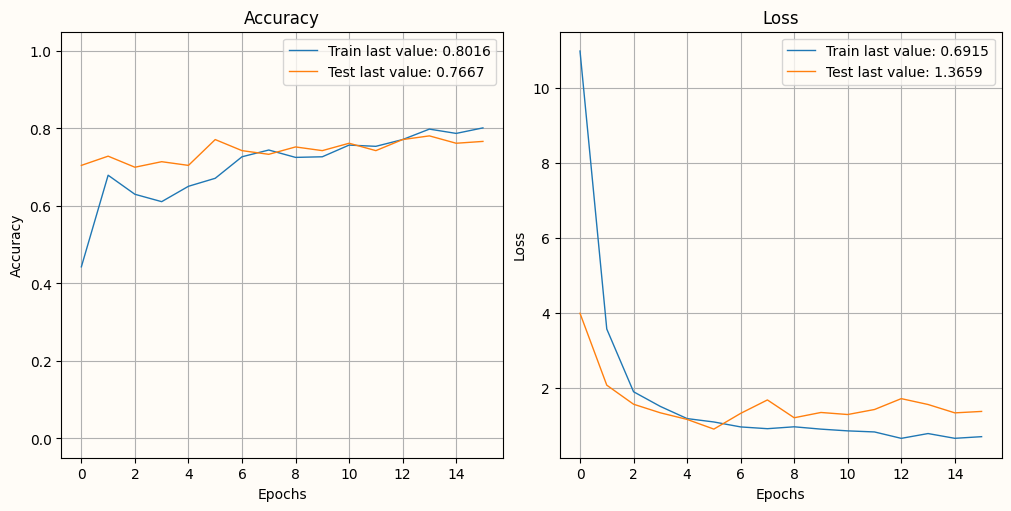

In [10]:
# Affichage de l'historique d'entraînement du modèle
show_history(history)